In [52]:
import os
import csv
import numpy as np
import pandas as pd
from prettytable import PrettyTable
from sklearn import linear_model, metrics
import scipy.stats as st
from scipy import interpolate
import matplotlib.pyplot as plt
import seaborn as sns
import copy

In [53]:
# Changing Directory
os.chdir("A:\\WebEconomics\\dataset")


In [54]:
# Reading Data
df = pd.read_csv('train.csv')
odf = df.copy()

## Selecting Wanted Features

In [55]:
# Define our features
features = ["click", "weekday", "hour", "region", "slotwidth", 'slotheight', 'bidprice', 'payprice']
df = df[features]
df = df.dropna()

In [56]:
df['slotsize'] = df['slotwidth'] * df['slotheight'] 
df.drop(['slotwidth', 'slotheight'], axis=1, inplace=True)

In [57]:
df.head()

,click,weekday,hour,region,bidprice,payprice,slotsize
0,0,1,14,80,300,54,28080
1,0,2,20,94,249,42,62500
2,0,5,9,216,300,76,94080
3,0,2,20,216,238,182,65520
4,0,6,9,40,238,34,85500


## Labeling and Categorising Data

Categorising:
- Hour: 
    - 0:00~07:59 : 1
    - 08:00~15:59: 2
    - 16:00~23:59: 3
- Size:
    - 0~40000     : 1
    - 40000~80000 : 2
    - 80000~120000: 3

In [58]:
df['hour'] = pd.cut(df['hour'], bins = [0,8,16,23.5], right=False, labels=[1,2,3])
df['slotsize'] = pd.cut(df['slotsize'], bins = [0,40000,80000,120000], right=True, labels=[1,2,3])
df.head()  

,click,weekday,hour,region,bidprice,payprice,slotsize
0,0,1,2,80,300,54,1
1,0,2,3,94,249,42,2
2,0,5,2,216,300,76,3
3,0,2,3,216,238,182,2
4,0,6,2,40,238,34,3


In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2697738 entries, 0 to 2697737
Data columns (total 7 columns):
click       int64
weekday     int64
hour        category
region      int64
bidprice    int64
payprice    int64
slotsize    category
dtypes: category(2), int64(5)
memory usage: 128.6 MB


In [60]:
df = df.dropna()
df.isnull().any().any()

False

### Dummy Coding

Since all of the variables are categorical integers, we need to convert these numbers into categorical type. To do this, we can use dummy coding. 

We will use [**``sklearn.preprocessing.LabelEncoder()``**](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html#sklearn.preprocessing.LabelEncoder)


Encode labels with value between 0 and n_classes-1.

In [61]:
#df["hour"] = df["hour"].cat.codes
#df["slotsize"] = df["slotsize"].cat.codes

In [62]:
from sklearn import preprocessing

# Set the random seed
np.random.seed(12)

# Initialize label encoder
label_encoder = preprocessing.LabelEncoder()

In [63]:
# Convert all the features to numeric values
df["click"] = label_encoder.fit_transform(df["click"])
df["weekday"] = label_encoder.fit_transform(df["weekday"])
df["region"] = label_encoder.fit_transform(df["region"])

df["hour"] = label_encoder.fit_transform(df["hour"])
df["slotsize"] = label_encoder.fit_transform(df["slotsize"])

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2697646 entries, 0 to 2697737
Data columns (total 7 columns):
click       int64
weekday     int64
hour        int64
region      int64
bidprice    int64
payprice    int64
slotsize    int64
dtypes: int64(7)
memory usage: 164.7 MB


In [65]:
df.head()

,click,weekday,hour,region,bidprice,payprice,slotsize
0,0,1,1,10,300,54,0
1,0,2,2,11,249,42,1
2,0,5,1,19,300,76,2
3,0,2,2,19,238,182,1
4,0,6,1,6,238,34,2


## Training Logistic Regression (linear_model.LogisticRegression)

### Spliting data into training and test set

To avoid **overfitting**, it is common practice when performing a (supervised) machine learning experiment to hold out part of the available data as a test set **``X_test, y_test``**. Now we will split the data into a training set and a testing set and then train our model.

We will use **[sklearn.model_selection.train_test_split](http://scikit-learn.org/stable/modules/cross_validation.html)**

In [66]:
try:
    from sklearn.model_selection import train_test_split, cross_val_score
except ImportError:
    from sklearn.cross_validation import train_test_split, cross_val_score

In [67]:
# Defining X and Y
X = df[[col for col in df.columns if col not in ['click']]]
Y = df['click']

In [68]:
# Train set is 60% of data and test set is 40% of data 
X_train, X_test, y_train, y_test = train_test_split(\
        X, Y, test_size=0.4, random_state=0)

### Choose the Estimator
We will use **[linear_model.LogisticRegression()](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)** from **`sklearn`** module.

Reference: [LR](http://hamelg.blogspot.co.uk/2015/11/python-for-data-analysis-part-28.html)

In [69]:
# Training the model
logreg = linear_model.LogisticRegression()

In [70]:
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [71]:
print(logreg.coef_)
print(logreg.intercept_)

[[ 0.00390046  0.12510586 -0.00247659 -0.00037636  0.004902   -0.26207333]]
[-7.3332323]


### Inspecting Scores of Test Data and Predicting Probability of Test Data

In [72]:
logreg.score(X_test, y_test)

0.99922988455682216

In [73]:
logreg.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [74]:
narray = logreg.predict(X_test)
print(narray.sum())

0


In [75]:
logreg.predict_proba(X_test)

array([[  9.99420432e-01,   5.79567564e-04],
       [  9.99184869e-01,   8.15130856e-04],
       [  9.99488794e-01,   5.11205811e-04],
       ..., 
       [  9.99471243e-01,   5.28757295e-04],
       [  9.99338567e-01,   6.61433323e-04],
       [  9.99335521e-01,   6.64478582e-04]])

In [76]:
probarray = logreg.predict_proba(X_test)
probdf =pd.DataFrame(probarray)

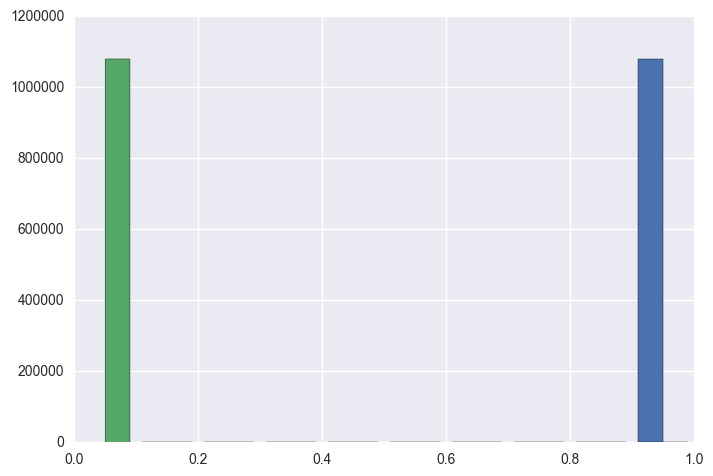

In [77]:
plt.hist(probarray)
#plt.yscale('log')
plt.show()

C:\Users\user\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


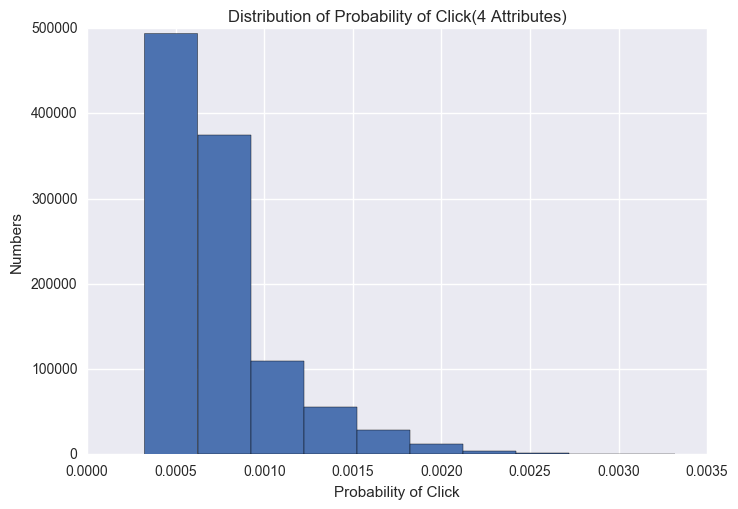

In [78]:
plt.xlabel('Probability of Click')
plt.ylabel('Numbers')
probdf.loc[:,1].hist()
#plt.yscale('log')
plt.title("Distribution of Probability of Click(4 Attributes)")
plt.legend()
plt.show()


In [79]:
pd.DataFrame(narray).to_csv('narray.csv', encoding='utf-8')
pd.DataFrame(probarray).to_csv('probarray.csv', encoding='utf-8')

### Mapping to Pay price_probdf (X_train)

In [80]:
f = interpolate.interp1d( [min(probdf.loc[:,1]) , max(probdf.loc[:,1])], [min(odf['payprice']), max(odf['payprice']) ])
probdf['estimatedBidPrice'] = probdf.loc[:,1].apply(  lambda x: f(x) )

In [81]:
probdf.head()

,0,1,estimatedBidPrice
0,0.999420,0.000580,25.636711
1,0.999185,0.000815,49.218736
2,0.999489,0.000511,18.793079
3,0.999525,0.000475,15.184659
4,0.999119,0.000881,55.849414


C:\Users\user\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


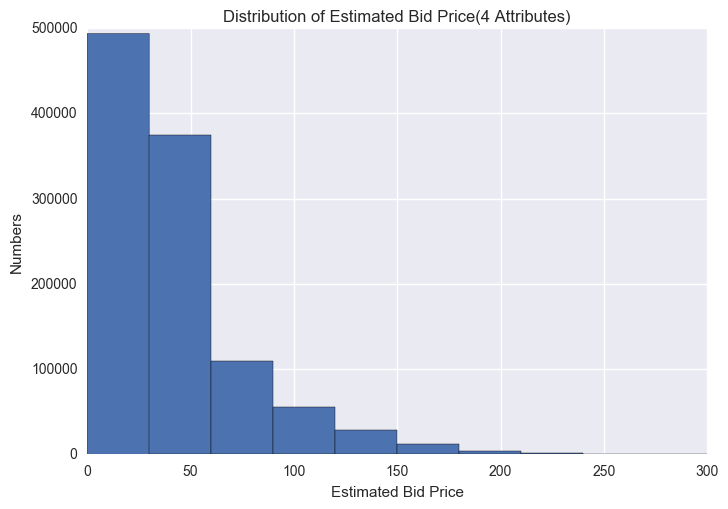

In [82]:
plt.xlabel('Estimated Bid Price')
plt.ylabel('Numbers')
probdf['estimatedBidPrice'].hist()
#plt.yscale('log')
plt.title("Distribution of Estimated Bid Price(4 Attributes)")
plt.legend()
plt.show()


### Mapping to Pay price_Whole training data set

In [83]:
x = PrettyTable(["Variable", 'Mean', 'Median','Variance', 'Skewness', 'Kurtosis', 'Min', 'Max'])
x.align["Variable"] = "l" # Left align city names 
x.padding_width = 0 # One space between column edges and contents (default)

x.add_row(["Bidprice", df['bidprice'].mean(), df['bidprice'].median(), df['bidprice'].var(), \
           st.skew(df['bidprice'],bias=False), st.kurtosis(df['bidprice'],bias=False), \
          min(df['bidprice']), max(df['bidprice'])])

x.add_row(["Payprice", df['payprice'].mean(), df['payprice'].median(), df['payprice'].var(), \
           st.skew(df['payprice'],bias=False), st.kurtosis(df['payprice'],bias=False), \
          min(df['payprice']), max(df['payprice'])])


print(x)

+--------+-----------------+------+------------------+-------------------+-------------------+---+---+
|Variable|       Mean      |Median|     Variance     |      Skewness     |      Kurtosis     |Min|Max|
+--------+-----------------+------+------------------+-------------------+-------------------+---+---+
|Bidprice|272.4580248854001|294.0 |847.3043511875072 |-0.3736851225027149|-1.6366827092589913|227|300|
|Payprice|80.25000018534678| 70.0 |3889.5651684689797| 1.249918361774527 | 1.0705845611422466| 0 |300|
+--------+-----------------+------+------------------+-------------------+-------------------+---+---+


#### Review:
Defining X and Y
- `X = df[[col for col in df.columns if col not in ['click']]]`
- `Y = df['click']`

In [84]:
logreg.fit(X, Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [87]:
logreg.predict_proba(X)[:,1]

array([ 0.00083678,  0.0007157 ,  0.00055249, ...,  0.00060063,
        0.00069582,  0.0004797 ])

In [88]:
df['logreg_prob'] = logreg.predict_proba(X)[:,1]

In [89]:
df.head()

,click,weekday,hour,region,bidprice,payprice,slotsize,logreg_prob
0,0,1,1,10,300,54,0,0.000837
1,0,2,2,11,249,42,1,0.000716
2,0,5,1,19,300,76,2,0.000552
3,0,2,2,19,238,182,1,0.001458
4,0,6,1,6,238,34,2,0.000468


C:\Users\user\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


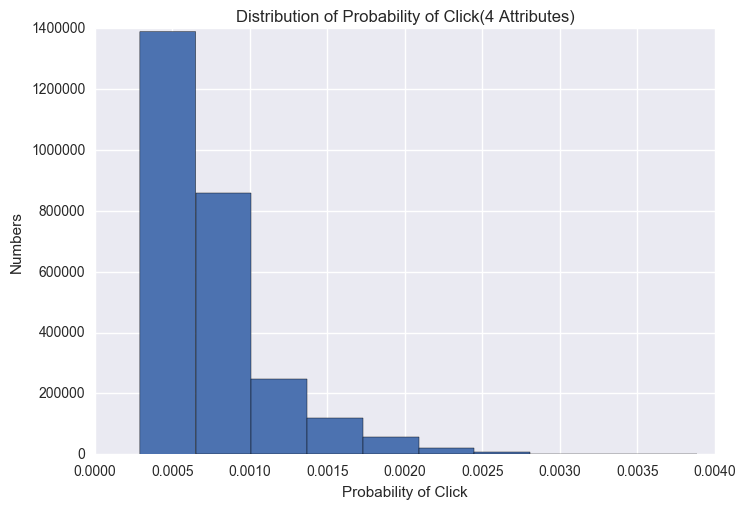

In [99]:
plt.xlabel('Probability of Click')
plt.ylabel('Numbers')
df['logreg_prob'].hist()
#plt.yscale('log')
plt.title("Distribution of Probability of Click(4 Attributes)")
plt.legend()
plt.show()


In [92]:
f = interpolate.interp1d( [min(df['logreg_prob']) , max(df['logreg_prob'])], [min(df['payprice']), max(df['payprice']) ])
df['estimatedBidPrice'] = df['logreg_prob'].apply(  lambda x: f(x) )

In [93]:
df.head()

,click,weekday,hour,region,bidprice,payprice,slotsize,logreg_prob,estimatedBidPrice
0,0,1,1,10,300,54,0,0.000837,45.604294
1,0,2,2,11,249,42,1,0.000716,35.504806
2,0,5,1,19,300,76,2,0.000552,21.890243
3,0,2,2,19,238,182,1,0.001458,97.446194
4,0,6,1,6,238,34,2,0.000468,14.833802


In [96]:
# information about pay price
print(df['payprice'].describe())
print("variance:", df['payprice'].var())
print("skewness:", st.skew(df['payprice'],bias=False))
print("kurtosis:", st.kurtosis(df['payprice'],bias=False))

count    2.697646e+06
mean     8.025000e+01
std      6.236638e+01
min      0.000000e+00
25%      3.300000e+01
50%      7.000000e+01
75%      1.010000e+02
max      3.000000e+02
Name: payprice, dtype: float64
variance: 3889.5651684689797
skewness: 1.249918361774527
kurtosis: 1.0705845611422466


C:\Users\user\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


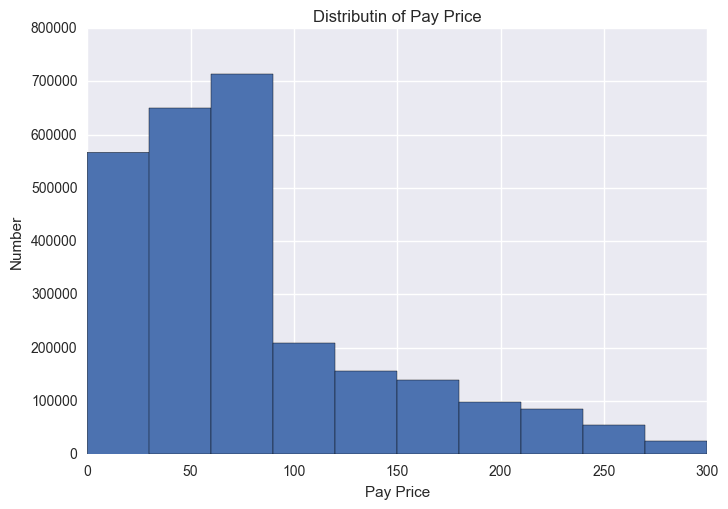

In [97]:
# plot histgram
plt.xlabel('Pay Price')
plt.ylabel('Number')
df['payprice'].hist()
plt.title("Distributin of Pay Price")
plt.legend()

plt.show()

In [95]:
# information about estimated bid price
print(df['estimatedBidPrice'].describe())
print("variance:", df['estimatedBidPrice'].var())
print("skewness:", st.skew(df['estimatedBidPrice'],bias=False))
print("kurtosis:", st.kurtosis(df['estimatedBidPrice'],bias=False))

count    2.697646e+06
mean     3.894896e+01
std      3.060468e+01
min      0.000000e+00
25%      1.971848e+01
50%      2.948002e+01
75%      4.661917e+01
max      3.000000e+02
Name: estimatedBidPrice, dtype: float64
variance: 936.6466662112609
skewness: 2.0854480902604915
kurtosis: 5.423929632465267


C:\Users\user\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


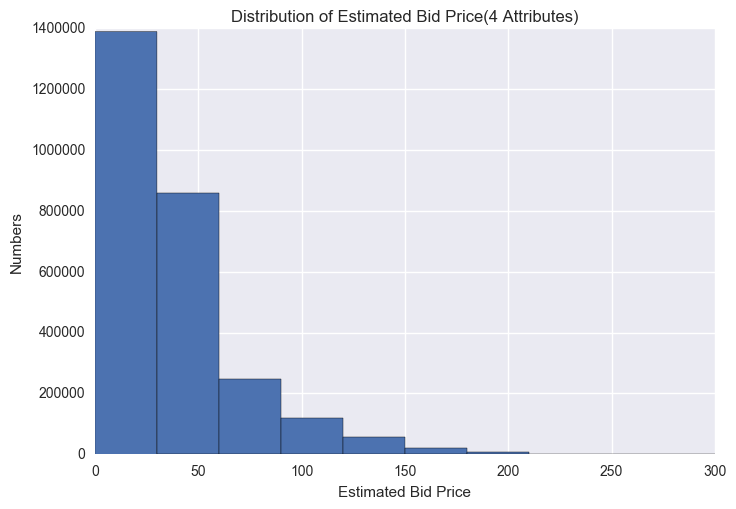

In [94]:
plt.xlabel('Estimated Bid Price')
plt.ylabel('Numbers')
df['estimatedBidPrice'].hist()
#plt.yscale('log')
plt.title("Distribution of Estimated Bid Price(4 Attributes)")
plt.legend()
plt.show()


## 0~600

In [115]:
ftest = interpolate.interp1d( [min(df['logreg_prob']) , max(df['logreg_prob'])], [min(df['payprice']), 600 ])
df['estimatedBidPrice_test'] = df['logreg_prob'].apply(  lambda x: ftest(x) )

C:\Users\user\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


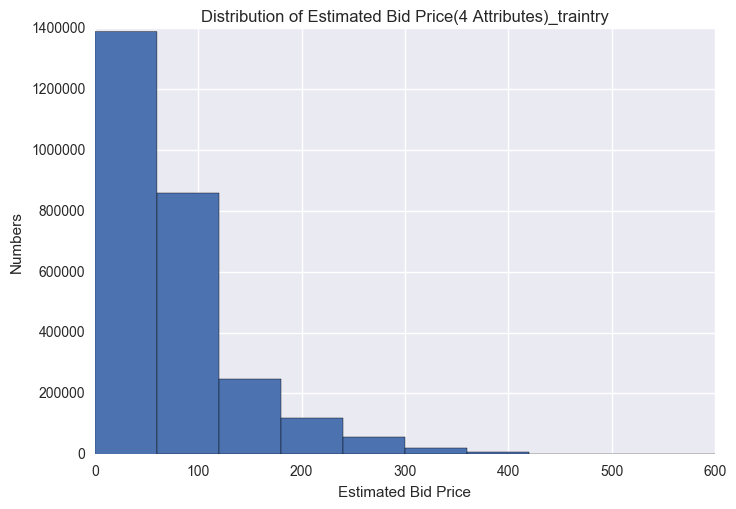

In [116]:
plt.xlabel('Estimated Bid Price')
plt.ylabel('Numbers')
df['estimatedBidPrice_test'].hist()
#plt.yscale('log')
plt.title("Distribution of Estimated Bid Price(4 Attributes)_traintry")
plt.legend()
plt.show()


In [117]:
# information about estimated bid price
print(df['estimatedBidPrice_test'].describe())
print("variance:", df['estimatedBidPrice_test'].var())
print("skewness:", st.skew(df['estimatedBidPrice_test'],bias=False))
print("kurtosis:", st.kurtosis(df['estimatedBidPrice_test'],bias=False))

count    2.697646e+06
mean     7.789793e+01
std      6.120937e+01
min      0.000000e+00
25%      3.943696e+01
50%      5.896004e+01
75%      9.323835e+01
max      6.000000e+02
Name: estimatedBidPrice_test, dtype: float64
variance: 3746.5866648450437
skewness: 2.0854480902604915
kurtosis: 5.423929632465267


## 0~300

In [121]:
ftesttry = interpolate.interp1d( [min(df['logreg_prob']) , max(df['logreg_prob'])], [0, max(df['bidprice']) ])
df['estimatedBidPrice_testtry'] = df['logreg_prob'].apply(  lambda x: ftesttry(x) )

C:\Users\user\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


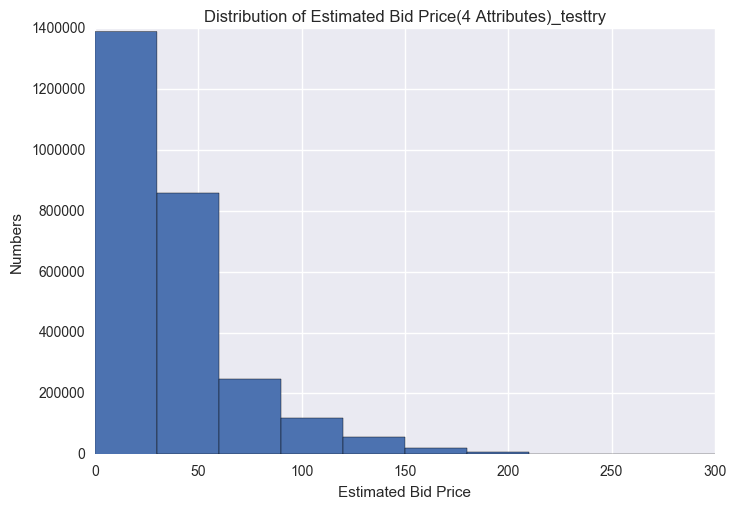

In [122]:
plt.xlabel('Estimated Bid Price')
plt.ylabel('Numbers')
df['estimatedBidPrice_testtry'].hist()
#plt.yscale('log')
plt.title("Distribution of Estimated Bid Price(4 Attributes)_testtry")
plt.legend()
plt.show()


In [123]:
# information about estimated bid price
print(df['estimatedBidPrice_testtry'].describe())
print("variance:", df['estimatedBidPrice_testtry'].var())
print("skewness:", st.skew(df['estimatedBidPrice_testtry'],bias=False))
print("kurtosis:", st.kurtosis(df['estimatedBidPrice_testtry'],bias=False))

count    2.697646e+06
mean     3.894896e+01
std      3.060468e+01
min      0.000000e+00
25%      1.971848e+01
50%      2.948002e+01
75%      4.661917e+01
max      3.000000e+02
Name: estimatedBidPrice_testtry, dtype: float64
variance: 936.6466662112609
skewness: 2.0854480902604915
kurtosis: 5.423929632465267


## X2.5

In [126]:
f2 = interpolate.interp1d( [min(df['logreg_prob']) , max(df['logreg_prob'])], [0, max(df['bidprice']) ])
df['estimatedBidPrice_x2.5'] = df['logreg_prob'].apply(  lambda x: f2(x)*2.5 )

C:\Users\user\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


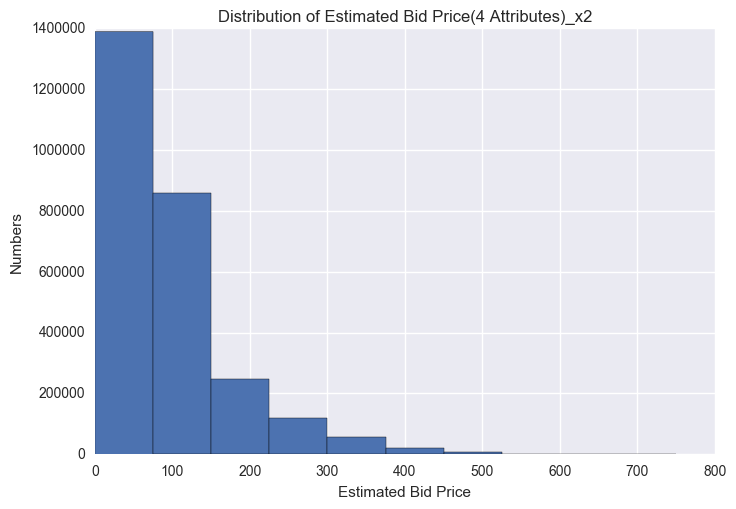

In [127]:
plt.xlabel('Estimated Bid Price')
plt.ylabel('Numbers')
df['estimatedBidPrice_x2.5'].hist()
#plt.yscale('log')
plt.title("Distribution of Estimated Bid Price(4 Attributes)_x2.5")
plt.legend()
plt.show()


In [128]:
# information about estimated bid price x2
print(df['estimatedBidPrice_x2'].describe())
print("variance:", df['estimatedBidPrice_x2'].var())
print("skewness:", st.skew(df['estimatedBidPrice_x2'],bias=False))
print("kurtosis:", st.kurtosis(df['estimatedBidPrice_x2'],bias=False))

count    2.697646e+06
mean     9.737241e+01
std      7.651171e+01
min      0.000000e+00
25%      4.929620e+01
50%      7.370005e+01
75%      1.165479e+02
max      7.500000e+02
Name: estimatedBidPrice_x2, dtype: float64
variance: 5854.041663820749
skewness: 2.0854480902604973
kurtosis: 5.423929632465288


## Training Logistic Regression (linear_model.LogisticRegressionCV)

In [ ]:
# Defining X and Y
X = df[[col for col in df.columns if col not in ['click']]]
Y = df['click']

In [ ]:
# Training the model
logregCV = linear_model.LogisticRegressionCV()

In [ ]:
logregCV.fit(X_train, y_train)
logregCV.predict_proba(X_test)

In [ ]:
logregCV.score(X_test, y_test)

In [ ]:
probarray1 = logregCV.predict_proba(X_test)
probdf1 =pd.DataFrame(probarray1)

In [ ]:
plt.xlabel('Probability of Click')
plt.ylabel('Numbers')
probdf1.loc[:,1].hist()
#plt.yscale('log')
plt.title("Distribution of Probability of Click(4 Attributes)_LogisticRegressionCV")
plt.legend()
plt.show()

## Training Logistic Regression (linear_model.SGDClassifier(loss='log'))

In [ ]:
# Defining X and Y
X = df[[col for col in df.columns if col not in ['click']]]
Y = df['click']

In [ ]:
# Training the model
SGDlog = linear_model.SGDClassifier(loss='log')

In [ ]:
SGDlog.fit(X_train, y_train)
SGDlog.predict_proba(X_test)

In [ ]:
SGDlog.score(X_test, y_test)

In [ ]:
probarray2 = logregCV.predict_proba(X_test)
probdf2 =pd.DataFrame(probarray2)

In [ ]:
plt.xlabel('Probability of Click')
plt.ylabel('Numbers')
probdf2.loc[:,1].hist()
#plt.yscale('log')
plt.title("Distribution of Probability of Click(4 Attributes)_SGDClassifier")
plt.legend()
plt.show()

## Implementing on Validation Set_Click or not click

In [ ]:
# Reading Data
df = pd.read_csv('train.csv')

In [ ]:
# Define our features
features = ["click", "weekday", "hour", "region", "slotwidth", 'slotheight']
df = df[features]
df = df.dropna()

In [ ]:
df['slotsize'] = df['slotwidth'] * df['slotheight'] 
df.drop(['slotwidth', 'slotheight'], axis=1, inplace=True)

In [ ]:
df['hour'] = pd.cut(df['hour'], bins = [0,8,16,23.5], right=False, labels=[1,2,3])
df['slotsize'] = pd.cut(df['slotsize'], bins = [0,40000,80000,120000], right=True, labels=[1,2,3])
df.head()  

### Plot the decision boundary. 
For that, we will assign a color to each point in the mesh [x_min, x_max]x[y_min, y_max].

In [ ]:
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, .02), np.arange(y_min, y_max, .02))
Z = logreg.predict(np.c_[xx.ravel(), yy.ravel()])

In [ ]:
# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(4, 3))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k', cmap=plt.cm.Paired)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())

plt.show()